![](https://bitcoinist.com/wp-content/uploads/2018/06/shutterstock_1018654609.jpg)

**Goal of this kernel is to compare NN and ARIMA modelling. We will be predicting Bitcoin prices with help of Bitcoin historical data.**

**Please note that the author of the datasets removed/changed them. Hence kernel is not fully functional. But the code is if the original data assumptions are met.**

**There are 4 csv files. CSV files for select bitcoin exchanges for the time period of Jan 2012 to July 2018, with minute to minute updates of OHLC (Open, High, Low, Close), Volume in BTC and indicated currency, and weighted bitcoin price. Timestamps are in Unix time. Timestamps without any trades or activity have their data fields forward filled from the last valid time period. If a timestamp is missing, or if there are jumps, this may be because the exchange (or its API) was down, the exchange (or its API) did not exist, or some other unforseen technical error in data reporting or gathering. **

coincheckJPY_1-min_data_2014-10-31_to_2018-06-27.csv

bitflyerJPY_1-min_data_2017-07-04_to_2018-06-27.csv

coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv

bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv

**All from different Bitcoin exchanges**

**RNN** To predict bitcoin prices

In [1]:
# First step, import libraries and then dataset
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt

In [2]:
# Import the dataset and encode the date
df = pd.read_csv("../input/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv")
df['date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

FileNotFoundError: File b'../input/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv' does not exist

Bitcoin predictions are going to be for a month, that is why we need to split the dataset accordingly

In [3]:
# split data
prediction_days = 30
df_train= Real_Price[len(Real_Price)-prediction_days:]
df_test= Real_Price[:len(Real_Price)-prediction_days]

NameError: name 'Real_Price' is not defined

Some pre-processing is also necessary:


In [4]:
# Data preprocess
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

NameError: name 'df_train' is not defined

Now keras  to build the rNN, Long short-term memory!!! LSTM

In [5]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 4, activation = 'sigmoid', input_shape = (None, 1)))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

Using TensorFlow backend.


NameError: name 'X_train' is not defined

**NOTE!!!** Key thing is following and that is why NN COULD "fail". WE used values of today to predict the future values. That is not really failure of NN but jsut goes to show that we need to think about what are we "feeding" our NN with. Because it can happen that NN will only learn that price will be slightly higher than yesterdays price. Which is true, except when it is not. Than we fail big.

In [6]:
test_set = df_test.values[1:]
sc = MinMaxScaler()
inputs = np.reshape(df_test.values[0:len(df_test)-1], (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

NameError: name 'df_test' is not defined

NameError: name 'test_set' is not defined

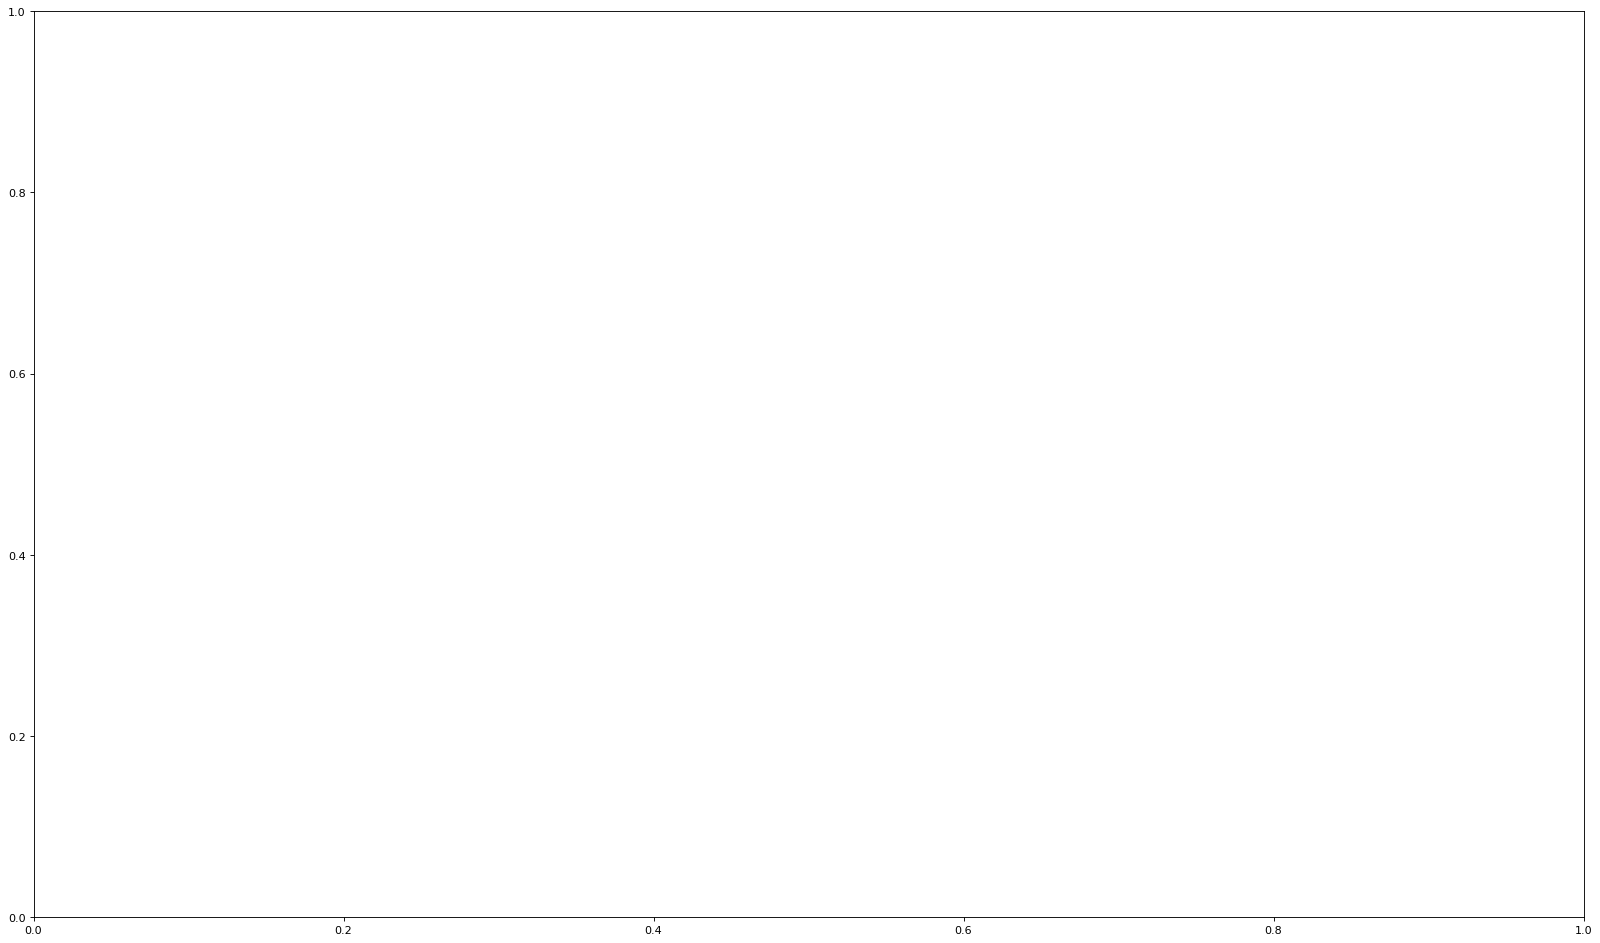

In [7]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_test.reset_index()
x=df_test.index
labels = df_test['date']
plt.xticks(x, labels, rotation = 'vertical')
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()


**ARIMA** Let us first go through theoretical part of ARIMA. (NN should be already familiar, if not visit my other kernels

An **ARIMA** model is a class of statistical models for analyzing and forecasting time series data. ARIMA model is one model for non-stationarity. It assumes that the data becomes stationary after differencing.

**ARIMA** is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.



These acronyms describe it pretty well:
1. **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
2.**I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
3. **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.



Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

Parameters are defined as follows:

1. **p**: The number of lag observations included in the model, also called the lag order.
2. **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
3. **q**: The size of the moving average window, also called the order of moving average.




**IMPORTANT**

Adopting an ARIMA model for a time series assumes that the underlying process that generated the observations is an ARIMA process. This may seem obvious, but helps to motivate the need to confirm the assumptions of the model in the raw observations and in the residual errors of forecasts from the model.

But how do we check that? And how to de determine the parameters p,d,q in the model?
First of all we need to make sure that the time-series is stationary, thats where differencing comes into place (degree corrects the level of non-stationarity if possible) And model parameters can be determined with the Box-Jenkins Method.

Basicaly we have the following situation:
1. Define the model by calling ARIMA() and passing in the p, d, and q parameters.
2. The model is prepared on the training data by calling the fit() function.
3. Predictions can be made by calling the predict() function and specifying the index of the time or times to be predicted.

How does **Box-Jenkins Method** work?
[https://machinelearningmastery.com/gentle-introduction-box-jenkins-method-time-series-forecasting/](http://)



Let us start coding

In [8]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [9]:
# Load data
df = pd.read_csv("../input/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv")
df.head()

FileNotFoundError: File b'../input/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv' does not exist

We need to transform our index into time data and then split the time intervals

In [10]:
# Unix-time to 
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

NameError: name 'df' is not defined

Visualize the trend

NameError: name 'df' is not defined

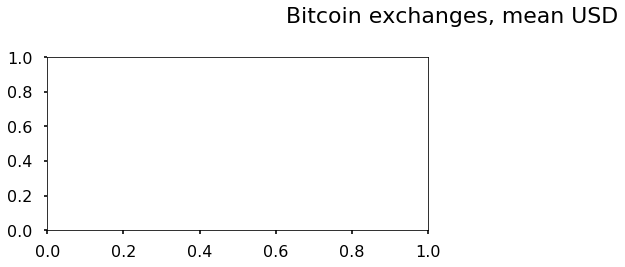

In [11]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

# plt.tight_layout()
plt.show()

**Stationarity check and STL-decomposition of the series*** Lower the p value the better. Stationarity is our models main assumption and dickey fuller is just hypothesis test of the unit root test

In [12]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

NameError: name 'df_month' is not defined

<Figure size 1080x504 with 0 Axes>

Obviously not stationary, hence we ought transform our data. First Box-cox transformation then check the test

In [13]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

NameError: name 'df_month' is not defined

We need another transformation. Seasonal differentiation

In [14]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

NameError: name 'df_month' is not defined

Again series is not stationary, finally let us try regular differentiation

In [15]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

NameError: name 'df_month' is not defined

Now we need to make model selection, with help of :
* Autocorrelation Function (ACF). The plot summarizes the correlation of an observation with lag values. The x-axis shows the lag and the y-axis shows the correlation coefficient between -1 and 1 for negative and positive correlation.
* Partial Autocorrelation Function (PACF). The plot summarizes the correlations for an observation with lag values that is not accounted for by prior lagged observations.
We can get a basic picture of the parameter interval, and using this heuristic we can  with help of AIC- Akaike information criterion decide which are the best p,q,d for ARIMA

In [16]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

NameError: name 'df_month' is not defined

In [17]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

ValueError: Length mismatch: Expected axis has 0 elements, new values have 2 elements

Good, now we can make predictions with our (ARIMA) model:

In [18]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [19]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30), 
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

NameError: name 'df_month' is not defined